In [1]:
# Do not change this cell

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(trainset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

/Users/griffinhsu/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/griffinhsu/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b)
  Referenced from: '/Users/griffinhsu/anaconda3/lib/python3.11/site-packages/torchvision/image.so'
  Expected in: '/Users/griffinhsu/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [2]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

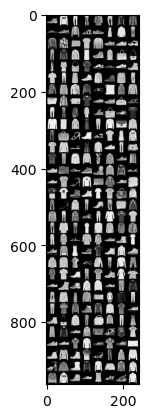

In [3]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [4]:
# TODO: you will design your model here

class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvModel, self).__init__()

        self.cnn_model = nn.Sequential(
            nn.Conv2d(input_size, out_channels=6, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
            nn.ReLU(),   
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
            
        )

        self.flat = nn.Flatten()
        self.fc_model = nn.Sequential(
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Linear(512,output_size)
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = self.flat(x)
        x = self.fc_model(x)
        return x



In [5]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    # TODO: implement one epoch of training
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass
        y_logit = model(X_train)
        train_loss = loss_fn(y_logit, y_train)

        # L2 regularization term
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param, 2)

        # Add regularization to the loss
        total_loss = train_loss + reg_param * l2_reg

        # Zero gradients, backward pass, and update step should be done within the loop for each batch
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(y_logit, 1)
        correct_predictions += (predicted == y_train).sum().item()
        total_samples += y_train.size(0)

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples * 100.0

    return train_loss.item(), accuracy

In [6]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    # TODO: implement evaluation on a data set, data_loader
    model.eval()
    
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for X_test, y_test in data_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)

        with torch.no_grad():
            y_test_logit = model(X_test)
            
            # For multi-class classification, use softmax activation
            y_test_predict = torch.argmax(torch.nn.functional.softmax(y_test_logit, dim=1), dim=1)
            
            test_loss = loss_fn(y_test_logit, y_test)

            if reg_param > 0:
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param, 2)
                test_loss += reg_param * l2_reg

            total_loss += test_loss.item()
            correct_predictions += torch.eq(y_test_predict, y_test).sum().item()
            total_samples += len(y_test)

    test_loss_avg = total_loss / len(data_loader)
    test_acc = (correct_predictions / total_samples) * 100

    return test_loss_avg, test_acc

In [7]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"

    torch.manual_seed(random_seed)  # do not change this

    # TODO: write codes to train your model here
    input_size = 1 
    output_size = 10  
    model = ConvModel(input_size, output_size).to(device)

    loss_fn = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 30
    reg_param = 0.01  
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()

        # Call your train_step function
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)

        # Validation
        valid_loss, valid_acc = evaluation_step(model, valid_loader, loss_fn, reg_param, device)

        # Testing
        test_loss, test_acc = evaluation_step(model, test_loader, loss_fn, reg_param, device)

        # Record metrics for this epoch
        training_losses.append(train_loss)
        training_accuracies.append(train_acc)
        validation_losses.append(valid_loss)
        validation_accuracies.append(valid_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Print or log the metrics for this epoch if needed
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.2f}%, '
              f'Validation Loss: {valid_loss:.4f}, Validation Acc: {valid_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return model, training_losses, training_accuracies, validation_losses, validation_accuracies, test_losses, test_accuracies


In [8]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
   # TODO: plot accuracy curves, you can reuse your codes from the simple classification task 
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Train Accuracies')
    plt.plot(valid_accuracies, label='Valid Accuracies')
    plt.plot(test_accuracies, label='Test Accuracies')
    plt.title('Accuracies During Training')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [9]:
def plot_loss_performance(train_losses, valid_accuracies, test_losses):
# TODO: plot loss curves, you can reuse your codes from the simple classification task
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Losses')
    plt.plot(valid_accuracies, label='Valid Losses')
    plt.plot(test_losses, label='Test Losses')
    plt.title('Losses During Training')
    plt.xlabel('Iteration')
    plt.ylabel('Losses')
    plt.legend()
    plt.show()

In [10]:
# Do not change this cell
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch 1/30 - Training Loss: 0.4947, Training Acc: 70.01%, Validation Loss: 0.8105, Validation Acc: 77.14%, Test Loss: 0.8265, Test Acc: 75.96%
Epoch 2/30 - Training Loss: 0.5103, Training Acc: 80.21%, Validation Loss: 0.7005, Validation Acc: 80.95%, Test Loss: 0.7181, Test Acc: 80.15%
Epoch 3/30 - Training Loss: 0.4262, Training Acc: 83.04%, Validation Loss: 0.6420, Validation Acc: 83.87%, Test Loss: 0.6590, Test Acc: 83.20%
Epoch 4/30 - Training Loss: 0.4064, Training Acc: 84.43%, Validation Loss: 0.5887, Validation Acc: 86.09%, Test Loss: 0.6079, Test Acc: 84.78%
Epoch 5/30 - Training Loss: 0.3678, Training Acc: 85.42%, Validation Loss: 0.5851, Validation Acc: 86.24%, Test Loss: 0.6004, Test Acc: 85.39%
Epoch 6/30 - Training Loss: 0.2497, Training Acc: 86.01%, Validation Loss: 0.5467, Validation Acc: 87.89%, Test Loss: 0.5633, Test Acc: 86.63%
Epoch 7/30 - Training Loss: 0.4082, Training Acc: 86.69%, Validation Loss: 0.5521, Validation Acc: 87.02%, Test Loss: 0.5743, Test Acc: 86.01%

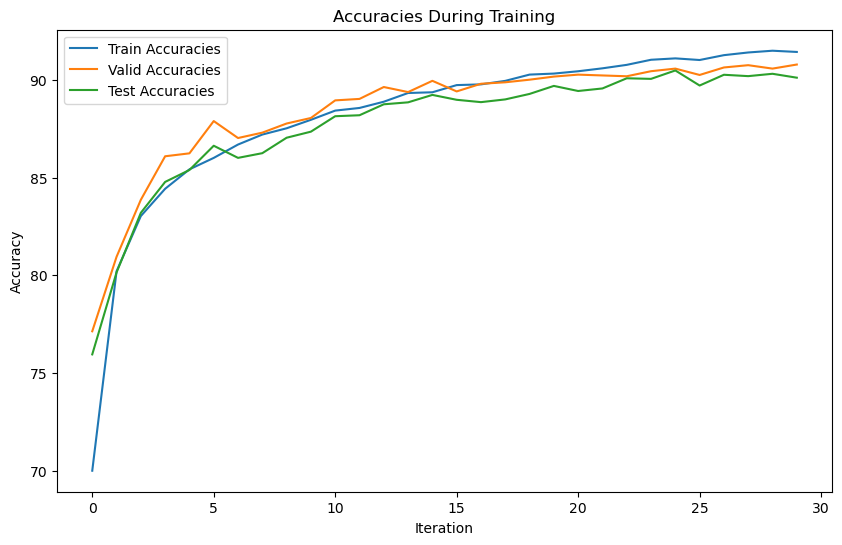

In [11]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

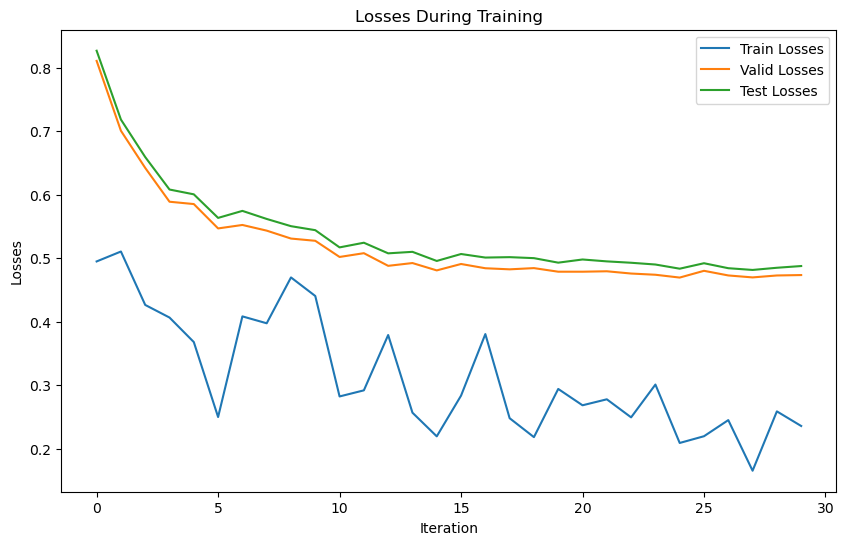

In [12]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)